# Tracking videos: Quads design (3dp pla + blue shims) for energy focusing


## Imports

In [1]:
import matplotlib.pyplot as plt
from typing import Union
from difflexmm.plotting import generate_animation
from difflexmm.geometry import current_coordinates
from difflexmm.utils import save_data, load_data, SolutionData
from problems.quads_focusing import OptimizationProblem
import cv2

from pathlib import Path
import pandas as pd
from scripts.tracking.tracking_gray_xcorr import tracking, mark_reference_frame
from scripts.tracking.utils import smooth_fields_SG
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Paths

In [2]:
# Where to load/save data
data_folder = Path("../../data/quads_focusing_3dp_pla_shims")
# Where to save plots and animations
out_folder = Path("../../out/quads_focusing_3dp_pla_shims")

## Problem info

NOTE: Either define the problem info here or load it from an optimization file.

In [4]:
# NOTE: Units are mm, N, s

# Retrieve design info from optimization data
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"{data_folder}/{optimization_filename}.pkl",
    )
)
problem = optimization.forward_problem
# Set up the forward problem
problem.setup()
geometry = problem.geometry

# Select the best design
design_values = optimization.design_values[-1]


## Rename video files

In [3]:
# # NOTE: Run this cell to rename the video files in human readable format!

# # Grab the video files
# video_paths = sorted(list(Path("videos/").glob("*.mp4")))  # Assumes filenames are in a known order

# # Define the experimental parameters used to generate the videos (in the same order as the video files)
# shaker_modes = ["burst"]*11 + ["burst"]*5 + ["burst"]*13
# voltages = list(jnp.arange(50., 300.+25., 25.)) + [200.]*5 + [200.]*13
# frequencies = [30.]*11 + [30.]*5 + list(jnp.arange(10., 50.+5, 5.)) + list(jnp.arange(60., 80.+10, 10.)) + [100.]

# assert len(voltages) == len(frequencies) == len(
#     shaker_modes), "Lengths of shaker modes, voltages, and frequencies must be equal"

# # Design name
# design_name = optimization_filename
# # Experimental video to be processed
# exp_filename = f"exp_{design_name}_shaker"

# # Rename the files
# for path, voltage, frequency, shaker_mode in zip(video_paths, voltages, frequencies, shaker_modes):
#     path.replace(path.parent/f"{exp_filename}_{shaker_mode}_{voltage:.0f}mV_{frequency:.0f}Hz_{path.stem}{path.suffix}")


## Videos to process


In [22]:
# Subfolder for videos and tracking data
design_name = optimization_filename

# Experimental videos to be processed
video_paths = sorted(list(Path(f"{data_folder}/{design_name}/videos").glob("*.mp4")),
                     key=lambda p: p.stem[-3:])

## Tracking


### Filenames and paths


In [24]:
# Define the tracked geometry i.e the reference geometry without clamped blocks
reference_centroids = geometry.block_centroids(*design_values)[problem.moving_blocks_ids]
reference_shapes = geometry.centroid_node_vectors(*design_values)[problem.moving_blocks_ids]


def morphological_transformation(thresh):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(transformed, cv2.MORPH_CLOSE, kernel, iterations=1)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # transformed = cv2.morphologyEx(transformed, cv2.MORPH_ERODE, kernel, iterations=1)
    return transformed


def add_clamped_blocks_data(tracked_data: SolutionData) -> SolutionData:
    """Add the data for the clamped blocks to the tracked data (for easier comparison with simulations)."""
    block_centroids = problem.geometry.block_centroids(*design_values)
    centroid_node_vectors = problem.geometry.centroid_node_vectors(*design_values)
    fields = jnp.zeros((len(tracked_data.timepoints), 2, len(block_centroids), 3))

    block_centroids = block_centroids.at[problem.moving_blocks_ids].set(tracked_data.block_centroids)
    centroid_node_vectors = centroid_node_vectors.at[problem.moving_blocks_ids].set(
        tracked_data.centroid_node_vectors
    )
    fields = fields.at[:, :, problem.moving_blocks_ids].set(tracked_data.fields)

    return SolutionData(
        block_centroids=block_centroids,
        centroid_node_vectors=centroid_node_vectors,
        bond_connectivity=problem.geometry.bond_connectivity(),
        timepoints=tracked_data.timepoints,
        fields=fields,
    )


def show_reference_frame(video_path: Union[str, Path], frame: int = 0):
    mark_reference_frame(
        video_path=str(video_path),
        calib_xy=(0.365, 0.365),  # mm/px (0.39, 0.39),
        ROI_X=(130, 1250),  # (80, 1120),
        ROI_Y=(0, 720),  # (20, 720),
        blur_size=1,
        threshold=45,  # 50,
        adaptive_thresholding=True,
        adaptive_thresholding_block=1001,
        morphological_transformation=morphological_transformation,
        block_area=(70, 3500),
        reference_centroids=reference_centroids,
        reference_shapes=reference_shapes,
        aspect_ratio_threshold=0.05,
        frame=frame,
        # Place markers a little bit closer to the centroid to have better features for cross-correlation.
        markers_scaled_position=0.85,
        show=True,
    )


def track_video(video_path: Union[str, Path], plot_centroids: bool = False, monitor_progress: bool = False):
    tracked_data = tracking(
        video_path=str(video_path),
        calib_xy=(0.365, 0.365),  # mm/px
        start_end_video=(50, 300),  # (0, 600),
        ROI_X=(130, 1250),
        ROI_Y=(0, 720),
        blur_size=1,
        threshold=45,
        adaptive_thresholding=True,
        adaptive_thresholding_block=1001,
        morphological_transformation=morphological_transformation,
        framerate=1000,
        block_area=(70, 3500),
        max_displacement_change=6.,  # mm
        reference_centroids=reference_centroids,
        reference_shapes=reference_shapes,
        # conv_size=[[2, 2, 4], [10, 10, 20]],
        aspect_ratio_threshold=0.05,
        # Cross-correlation parameters
        marker_template_size=20,  # px
        search_window_size=30,  # px
        upscaling_factor=5,
        # Place markers a little bit closer to the centroid to have better features for cross-correlation.
        markers_scaled_position=0.85,
        monitor_progress=monitor_progress,
    )
    # Add the data for the clamped blocks
    tracked_data = add_clamped_blocks_data(tracked_data)
    # Shift timepoints to start at 0
    tracked_data = tracked_data._replace(timepoints=tracked_data.timepoints - tracked_data.timepoints[0])
    # Smooth the data with a Savitzky-Golay filter
    tracked_data._replace(fields=smooth_fields_SG(tracked_data.fields, window_length=11, polyorder=3))

    if plot_centroids:
        # Plot centroids
        plt.figure(figsize=(8, 8*(geometry.n2_blocks+1)/geometry.n1_blocks), constrained_layout=True)
        plt.title(r"Centroids - frame \#0")
        plt.scatter(*reference_centroids.T, label="Reference")
        plt.scatter(*tracked_data.block_centroids[problem.moving_blocks_ids].T, label="Tracked")
        plt.scatter(*tracked_data.block_centroids[problem.clamped_blocks_ids].T, label="Clamped")
        for i, pt in enumerate(tracked_data.block_centroids):
            plt.text(*pt, f"{i}")
        plt.axis("equal")
        plt.legend(bbox_to_anchor=(0.5, -0.08), loc='center', ncol=3)

    return tracked_data


### Process one video


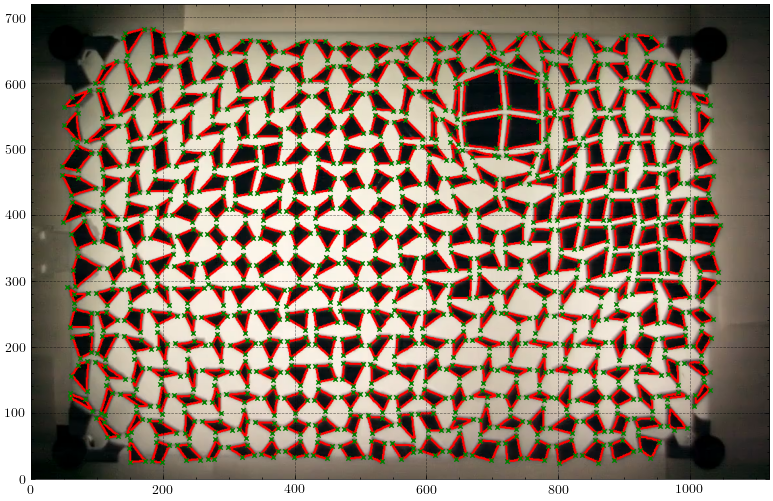

In [25]:
show_reference_frame(video_paths[6], frame=0)


In [ ]:
# t = track_video(video_paths[6], plot_centroids=True, monitor_progress=True)


### Process videos in bulk

In [ ]:
# # Filter the videos that we want to process
# all_videos = pd.DataFrame({
#     "label": [p.stem for p in video_paths],
#     "shaker_mode": [p.stem.split("_")[-4] for p in video_paths],
#     "voltage": [float(p.stem.split("_")[-3][:-2]) for p in video_paths],
#     "frequency": [float(p.stem.split("_")[-2][:-2]) for p in video_paths],
#     "path": video_paths,
# })
# videos_to_process = all_videos

# # Track each video and save the tracked data
# for path in videos_to_process["path"]:
#     tracked_data = track_video(path)
#     save_data(f"{data_folder}/{design_name}/dynamic-data/tracking_exp/{path.stem}.pkl", tracked_data._asdict())


## Load tracking data


In [31]:
# Find all data files in the dynamic-data folder
tracked_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/tracking_exp/").glob("*.pkl")), key=lambda p: p.stem[-2:])

# Load the tracked data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
tracked_data = pd.DataFrame({
    "label": [p.stem for p in tracked_data_paths],
    "shaker_mode": [p.stem.split("_")[-4] for p in tracked_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in tracked_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in tracked_data_paths],
    "data": [SolutionData(**load_data(p)) for p in tracked_data_paths],
})

excited_blocks_ids = problem.driven_blocks_ids
tracked_data


,label,shaker_mode,voltage,frequency,data
0,exp_shaker_burst_50mV_30Hz_F01,burst,50.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
1,exp_shaker_burst_75mV_30Hz_F02,burst,75.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
2,exp_shaker_burst_100mV_30Hz_F03,burst,100.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
3,exp_shaker_burst_125mV_30Hz_F04,burst,125.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
4,exp_shaker_burst_150mV_30Hz_F05,burst,150.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
5,exp_shaker_burst_175mV_30Hz_F06,burst,175.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
6,exp_shaker_burst_200mV_30Hz_F07,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
7,exp_shaker_burst_225mV_30Hz_F08,burst,225.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
8,exp_shaker_burst_200mV_30Hz_F12,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
9,exp_shaker_burst_200mV_30Hz_F13,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."


### Plot input signals


In [32]:
def plot_shaker_input(tracked_data, DOF=0):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)

    for row in tracked_data.itertuples():
        axes.plot(
            row.data.timepoints,
            row.data.fields[:, 0, excited_blocks_ids[0], DOF],
            label=f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz",
            lw=2,
        )

    axes.axhline(0, color="black", ls="-", lw=1)
    axes.set(xlabel="Time [s]", ylabel="Displacement [mm]")
    axes.set(title=f"Shaker input - DOF {DOF}")
    axes.legend(loc='upper right')


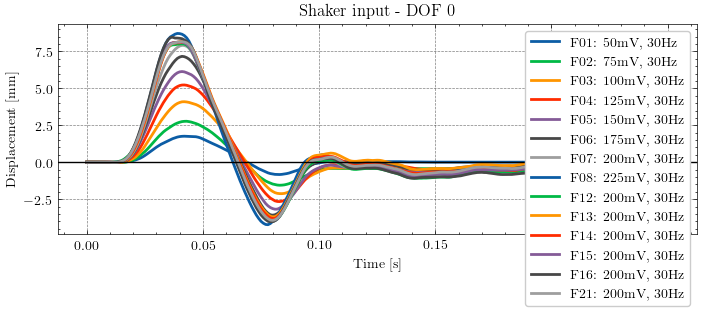

In [35]:
plot_shaker_input(
    tracked_data
)


### Animation of tracked experiments


In [ ]:
# Animation tracked experiments
xlim, ylim = problem.geometry.get_xy_limits(*design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

for row in tracked_data.itertuples():
    generate_animation(
        row.data,
        frame_range=jnp.arange(0, row.data.timepoints.shape[0], 2),
        field="u",
        deformed=True,
        out_filename=f"{out_folder}/{optimization_filename}/tracking_exp/{row.label}",
        xlim=xlim,
        ylim=ylim,
        figsize=(8, 5),
        fps=30,
        dpi=300,
    )
